# Generate Anime Faces

### Load the Data

In [1]:
import matplotlib.pyplot as plt
import PIL
import glob
import random as rd
import tensorflow
import keras.layers as layers
from keras.models import Sequential
import keras
import time
import numpy as np
from collections import Counter
from IPython import display

In [2]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
print(physical_devices)
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
START_SECTION = 45000
END_SECTION = 60000
EPOCHS = 15
BATCH_SIZE = 256
BUFFER_SIZE = 500
DESIRED_DIM = 64, 64  # do something easily makeable w/ conv2D transpose

In [4]:
file_names = glob.glob("./images/*.jpg")
file_names[:5]


['./images\\0_2000.jpg',
 './images\\10000_2004.jpg',
 './images\\10001_2004.jpg',
 './images\\10002_2004.jpg',
 './images\\10003_2004.jpg']

Height: 104, width: 104


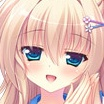

In [5]:
img = PIL.Image.open(rd.choice(file_names))
print(f"Height: {img.height}, width: {img.width}")
img


### Preprocess the Data

Not all the images are the same size. We want to fix this. So, we will be resizing all the images to a standard size.

In [6]:
"""
# analyze the spread of the ranges
dims = []
for file_name in file_names:
    img = PIL.Image.open(file_name)
    dims.append(img.width)

w = Counter(dims)
plt.bar(w.keys(), w.values())
"""


'\n# analyze the spread of the ranges\ndims = []\nfor file_name in file_names:\n    img = PIL.Image.open(file_name)\n    dims.append(img.width)\n\nw = Counter(dims)\nplt.bar(w.keys(), w.values())\n'

In [7]:
"""
print(w.most_common(1))
DESIRED_DIM = tuple([w.most_common(1)[0][0]] * 2)
print(f"Our desired dimensions are thus {DESIRED_DIM}")
del dims
del w
"""

'\nprint(w.most_common(1))\nDESIRED_DIM = tuple([w.most_common(1)[0][0]] * 2)\nprint(f"Our desired dimensions are thus {DESIRED_DIM}")\ndel dims\ndel w\n'

In [8]:
images_as_arrays = []
for file_name in file_names[START_SECTION:END_SECTION]:
    images_as_arrays.append(np.array(PIL.Image.open(file_name).resize(DESIRED_DIM)))


In [9]:
images_as_arrays = np.array(images_as_arrays, dtype="float32")

In [10]:
# put everything in float mode
images_as_arrays /= np.float32(256)

(15000, 64, 64, 3)


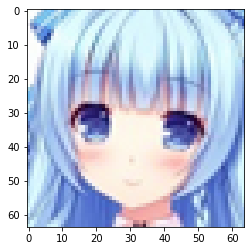

In [11]:
print(images_as_arrays.shape)
plt.imshow(images_as_arrays[0])

In [12]:
images_dataset = tensorflow.data.Dataset.from_tensor_slices(tensorflow.constant(images_as_arrays)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
# if needed, clean up some memory
#del images_as_arrays
#del images_dataset

### Make the Models

In [14]:
NUM_CHANNELS = 3  # number of channels in a color image

In [15]:
def make_generator():
    FACTORS = 243
    model = Sequential()
    model.add(
        layers.Dense(4 * 4 * NUM_CHANNELS * FACTORS, input_shape=(200,))
    )
    model.add(layers.SyncBatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.015))
    model.add(layers.Reshape((4, 4, NUM_CHANNELS * FACTORS)))

    model.add(layers.Conv2DTranspose(FACTORS, (9, 9), strides=(2, 2), padding="same"))
    model.add(layers.SyncBatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.015))
    
    model.add(layers.Conv2DTranspose(FACTORS//3, (9, 9), strides=(2, 2), padding="same"))
    model.add(layers.SyncBatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.015))

    model.add(layers.Conv2DTranspose(FACTORS//9, (3, 3), strides=(2, 2), padding="same"))
    model.add(layers.SyncBatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.015))

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding="same", activation='sigmoid'))
    
    return model


In [16]:
generator = make_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11664)             2344464   
                                                                 
 sync_batch_normalization (S  (None, 11664)            46656     
 yncBatchNormalization)                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 11664)             0         
                                                                 
 dropout (Dropout)           (None, 11664)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 729)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 243)        14349150  
 nspose)                                                

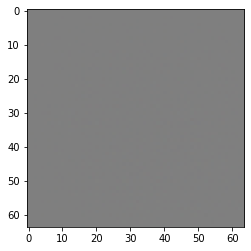

In [17]:
seed = tensorflow.random.normal((1, 200))
generated_img = generator(seed, training=False)
plt.imshow(generated_img[0])

In [18]:
def make_discriminator():
    model = Sequential()
    model.add(
        layers.Conv2D(
            9,
            (9, 9),
            strides=(2, 2),
            padding="same",
            input_shape=(DESIRED_DIM[0], DESIRED_DIM[1], NUM_CHANNELS,),
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(81, (9, 9), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(243, (9, 9), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(729))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))
    return model


In [19]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 9)         2196      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 9)         0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 9)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 81)        59130     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 81)        0         
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 81)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 243)        

### Prepare to train

In [20]:
# generate images along the way
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis("off")

    plt.savefig("./generatedAnimeFaces/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()


In [ ]:
# if needed, make sure that generate_and_save_images works
# generate_and_save_images(generator, 1, tensorflow.random.normal((16, 200)))


#### Prepare optimizers and loss functions

In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)


In [22]:
# discriminator loss
def discriminator_loss(real_output, fake_output):
    # all the real images should be 1's
    real_loss = cross_entropy(tensorflow.ones_like(real_output), real_output)
    # all the fake images should be 0's
    fake_loss = cross_entropy(tensorflow.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [23]:
def generator_loss(fake_output):
    # the generator's goal is to have all the fake images it generated
    # be classified as 1's by the discriminator
    return cross_entropy(tensorflow.ones_like(fake_output), fake_output)


In [24]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)


### Train

In [25]:
noise_dim = 200
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tensorflow.random.normal([num_examples_to_generate, noise_dim])


In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tensorflow.function
def train_step(images):
    noise = tensorflow.random.normal([BATCH_SIZE, noise_dim])

    with tensorflow.GradientTape() as gen_tape, tensorflow.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )


In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1786, seed)

        # Save the model every 3 epochs
        if (epoch + 1) % 3 == 0:
            generator.save("./generatorContinued")
            discriminator.save("./discriminatorContinued")

        print("Time for epoch {} is {} sec".format(epoch + 1786, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


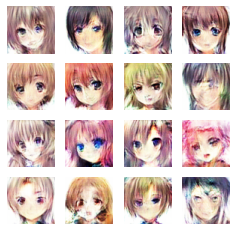

INFO:tensorflow:Assets written to: ./generatorContinued\assets


INFO:tensorflow:Assets written to: ./generatorContinued\assets


INFO:tensorflow:Assets written to: ./discriminatorContinued/assets


INFO:tensorflow:Assets written to: ./discriminatorContinued/assets


In [27]:
train(images_dataset, EPOCHS)
generator.save("./generatorContinued")
discriminator.save("./discriminatorContinued/")

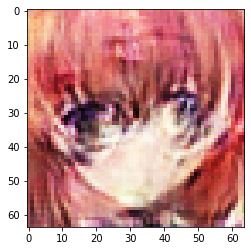

In [42]:
rand_noise = tensorflow.random.normal((1, 200))
generated_img = generator(rand_noise, training=False)
plt.imshow(generated_img[0])

### Load the generator and discriminator

In [37]:
# note that this requires you to have initialized the generator, discriminator
# already using make_generator and make_discriminator
generator.load_weights("./generatorContinued/")
discriminator.load_weights("./discriminatorContinued/")

### Satisfied with the results?

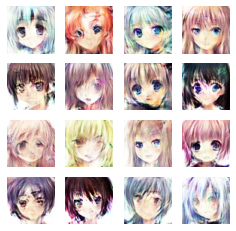

In [45]:
generate_and_save_images(generator, -1, tensorflow.random.normal((16, 200)))

In [44]:
generator.save("./generator")
discriminator.save("./discriminator/")

INFO:tensorflow:Assets written to: ./generator\assets


INFO:tensorflow:Assets written to: ./generator\assets


INFO:tensorflow:Assets written to: ./discriminator/assets


INFO:tensorflow:Assets written to: ./discriminator/assets


## Watch The Evolution

In [ ]:
import imageio
import tensorflow_docs.vis.embed as embed

In [ ]:
anim_file = 'animeEvolution.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
embed.embed_file(anim_file)